In [1]:
# Libraries

%matplotlib inline
import math
import numpy as np
import pandas as pd
from scipy import stats  
import matplotlib.pyplot as plt
from pyrsgis import raster
from matplotlib import colors as c


import warnings
warnings.filterwarnings('ignore')

In [2]:
#import geospatial libraries
import os
from glob import glob
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from pyrsgis import raster
from pyrsgis.convert import changeDimension

#import raster processing libraries
from shapely.geometry import MultiPoint, Polygon
import rasterio as rio
from rasterio.plot import plotting_extent

import cv2
import pylab as plt
import math
from skimage.color import rgb2hsv
import imageio

#import Keras
import keras
import keras.backend as K
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

#tensorflow
import tensorflow as tf

#Seaborn
import seaborn as sn

#import sklearn libraries
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from IPython.display import clear_output
clear_output()

In [3]:
#Create polygon as shape file from cooridinates to crop LANDSAT image
#corner 1: upper right
lat1 = 35.9018
lon1 = -121.3740

#corner 2 - upper left
lat2 = 35.8978
lon2 = -121.4557

#corner3 - lower left
lat3 = 35.8309
lon3 = -121.4503

#corner 4 - lower right
lat4 = 35.8360
lon4 = -121.3703

#Latitude and longitde lists
latlist = [lat1,lat2,lat3,lat4]
lonlist = [lon1,lon2,lon3,lon4]

#Create polygon
polygon_geom = Polygon(zip(lonlist, latlist))
crs = {'init': 'epsg:4326'}
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
print(polygon.geometry)
polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")

0    POLYGON ((-121.37400 35.90180, -121.45570 35.8...
Name: geometry, dtype: geometry


In [4]:
#open original image downloaded from Earthexplorer
landsat_postlandslide_path = os.path.join('LC08_CU_002010_20170927_20210503_02_SR','LS_tiff')
postlandslide_paths = glob(os.path.join(landsat_postlandslide_path, "*b*.TIF"))

#list of paths for LANDSAT bands
postlandslide_paths.sort()
postlandslide_paths

['C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\LS_tiff\\LC08_CU_002010_20170927_20210503_02_SR_B1.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\LS_tiff\\LC08_CU_002010_20170927_20210503_02_SR_B2.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\LS_tiff\\LC08_CU_002010_20170927_20210503_02_SR_B3.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\LS_tiff\\LC08_CU_002010_20170927_20210503_02_SR_B4.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\LS_tiff\\LC08_CU_002010_20170927_20210503_02_SR_B5.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\LS_tiff\\LC08_CU_002010_20170927_20210503_02_SR_B6.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_2017

In [5]:
#Create output directory for cropped bands
output_dir = os.path.join(landsat_postlandslide_path, "outputs_2")
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)

#Crop original image using lat-lon shapefile defined above
crop_bound = gpd.read_file('polygon.shp')
with rio.open(postlandslide_paths[0]) as raster_crs:
    crop_raster_profile = raster_crs.profile
    crop_bound = crop_bound.to_crs(crop_raster_profile["crs"])
    
postlandslide_paths_crop = es.crop_all(postlandslide_paths, output_dir, crop_bound, overwrite=True)

In [6]:
#Function to open landsat image as an array
def open_clean_bands(band_path):
    return rxr.open_rasterio(band_path, masked=True).squeeze()

In [14]:
landsat_postlandslide_path = os.path.join('LC08_CU_002010_20170927_20210503_02_SR','outputs')
postlandslide_paths = glob(os.path.join(landsat_postlandslide_path, "*b*.TIF"))

#Cropped band path list
postlandslide_paths.sort()
postlandslide_paths

['C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\outputs\\LC08_CU_002010_20170927_20210503_02_SR_B1_crop.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\outputs\\LC08_CU_002010_20170927_20210503_02_SR_B2_crop.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\outputs\\LC08_CU_002010_20170927_20210503_02_SR_B3_crop.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\outputs\\LC08_CU_002010_20170927_20210503_02_SR_B4_crop.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\outputs\\LC08_CU_002010_20170927_20210503_02_SR_B5_crop.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj\\LANDSAT\\LC08_CU_002010_20170927_20210503_02_SR\\outputs\\LC08_CU_002010_20170927_20210503_02_SR_B6_crop.TIF',
 'C:\\Users\\Keru\\Documents\\UT_MCHNLRN\\proj

In [10]:
# Open all bands in a loop
all_bands = []
for i, aband in enumerate(postlandslide_paths):
    all_bands.append(open_clean_bands(aband))
    # Assign a band number to the new xarray object
    all_bands[i]["band"]=i+1
    
landsat_postlandslide_crop_xr = xr.concat(all_bands, dim="band") 
landsat_postlandslide_crop_xr;

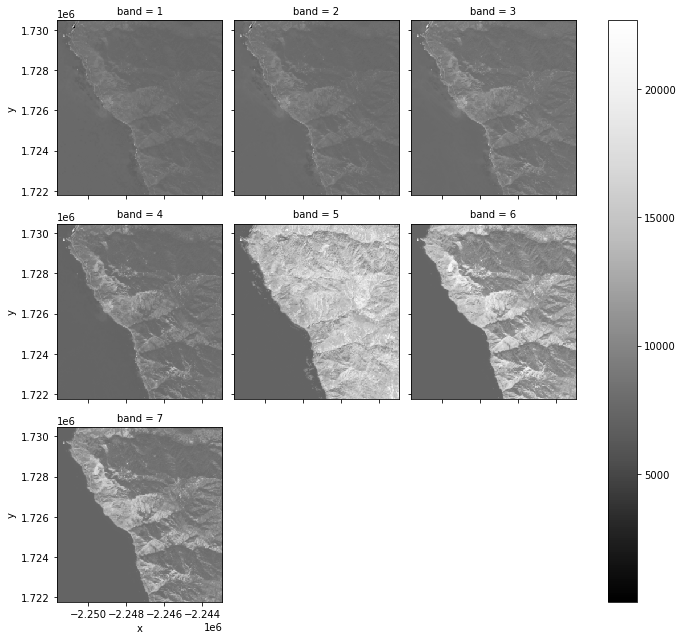

In [11]:
landsat_postlandslide_crop_xr.plot.imshow(col="band",col_wrap=3,cmap="Greys_r")
#plt.tight_layout()
#plt.savefig('Postlandslide.png')

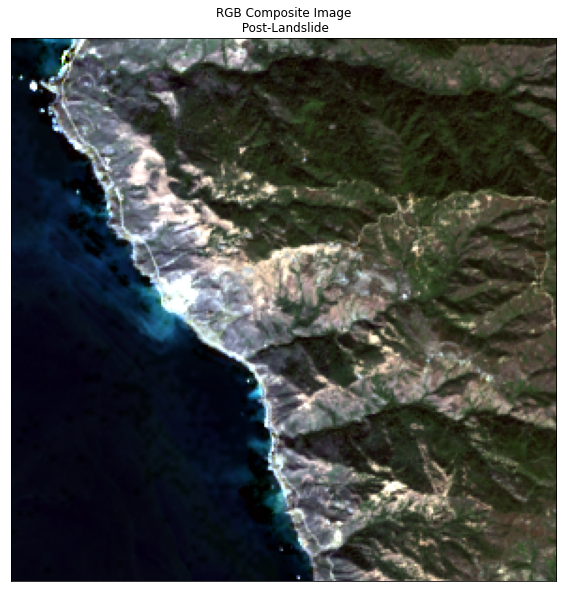

<AxesSubplot:title={'center':'RGB Composite Image\n Post-Landslide'}>

In [12]:
#Plot rgb composite
ep.plot_rgb(landsat_postlandslide_crop_xr.values,
            rgb=[3, 2, 1],
            title="RGB Composite Image\n Post-Landslide",stretch=True,str_clip=1)

#Image shows the 2017 Mud Creek landslide in California (bright patch near middle of image)
#The ground truth classification used as input to the machine learning algorithm was created in QGIS.

In [15]:
#import base image (same as bands in previous cell)
base_im = 'LS_tiff/LC08_CU_002010_20170927_20210503_02_SR_mergeclip.tif'
#import ground truth from QGIS output
labels_out = 'LS_tiff/MC_landcover.tif'

# Read the rasters as arrays
features1, features = raster.read(base_im, bands='all')
labels1, labels = raster.read(labels_out, bands=1)

In [16]:
#print out shapes of the feature and label data
print(" multispectral image shape: ", features.shape)
print(" Ground truth image shape: ", labels.shape)

 multispectral image shape:  (7, 472, 575)
 Ground truth image shape:  (472, 575)


In [17]:
#reshape features to be (271400,7)
features = changeDimension(features)
#reshape labels to be (271400,1)
labels = changeDimension(labels)
#number of bands
nBands = features.shape[1]

#One hot encoder to encode the labels as 2 = (0,1,0,0,0) ect. 
enc = OneHotEncoder()
Y = enc.fit_transform(labels[:, np.newaxis]).toarray()

#print image shapes
print(" Image shape: ", features.shape)
print("Ground truth image shape: ", labels.shape)
print('Bands: ',nBands)

The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
 Image shape:  (271400, 7)
Ground truth image shape:  (271400,)
Bands:  7


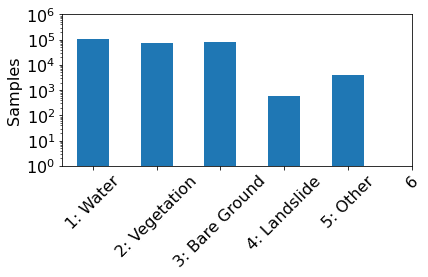

In [18]:
#Class definitions
lbls = ['1: Water','2: Vegetation','3: Bare Ground','4: Landslide','5: Other','6']

#plot histogram
ticks = [1,2,3,4,5,6]
plt.hist(labels, bins = ticks,align='left',rwidth=0.5);
plt.xticks(ticks, lbls,rotation=45,fontsize = 16);
plt.ylabel('Samples',fontsize = 16);
plt.ylim([1,10e5])
plt.yticks(fontsize=16);
plt.tight_layout()
plt.yscale('log')
#plt.savefig('Histogram.svg')

In [19]:
#Create 60-40 train test split and output test and training data shapes
X_train, X_test, Y_train, Y_test = train_test_split(features, Y, test_size=0.4, random_state=42)

print('X-train shape: ', X_train.shape)
print('Y-train shape: ', Y_train.shape)

print('X-test shape: ', X_test.shape)
print('Y-test shape: ', Y_test.shape)

X-train shape:  (162840, 7)
Y-train shape:  (162840, 5)
X-test shape:  (108560, 7)
Y-test shape:  (108560, 5)


In [20]:
# Normalise pixel values from 0-1
X_train = X_train / 255.
X_test = X_test / 255.
features = features / 255.

In [21]:
#Callbacks
#Class to compute F1-score at the end of each epoch through the callback method on_epoch_end.
class F1(keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(F1, self).__init__()
        self.validation_data = valid_data 
     
    #Computes f1 score
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        #Arg max returns the index with the maxium value. Since these labels were encoded, the values returned to y_pred
        #and y_test are 0-2 and need to be adjusted to 1-3.
        y_pred = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        y_test = np.argmax(self.validation_data[1], axis=1)
        f1 = f1_score(y_pred, y_test, average='micro')
        logs['f1 score'] = f1
        print("f1 score: %f" % (f1))
        return
    
#Create checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='Best_model', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto')

early_stopping = keras.callbacks.EarlyStopping(patience=100, verbose = 1)

#Callback list
callbacks = [early_stopping,model_checkpoint]

In [22]:
# Define the parameters of the neural network and build the model

nodes = 14
input_dim = features.shape[1]
output_dim = Y.shape[1]

model = Sequential()
#create first hidden layer with 14 nodes
model.add(Dense(nodes,input_dim=input_dim, activation='relu'))
#Create second hidden layer with 14 nodes
model.add(Dense(nodes,input_dim=input_dim, activation='relu'))
#Create output layer with 5 nodes (same as number of labels)
model.add(Dense(output_dim, activation='softmax'))

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                112       
                                                                 
 dense_1 (Dense)             (None, 14)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 75        
                                                                 
Total params: 397
Trainable params: 397
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Create history dictionary
history_dict = {}
model_name = 'Model 1'

#because of the 80-20 split, the validation dataset is the same as the training dataset
#Fit model
history_callback = model.fit(X_train, Y_train,batch_size=None,epochs=50,verbose=0,validation_data=(X_test, Y_test),
                             callbacks=[callbacks,F1(valid_data=(X_test, Y_test))])

#Evaluate model for final Test loss and Accuracy
score = model.evaluate(X_test, Y_test, verbose=1)
#make preduction from final model
Y_pred = model.predict(X_test)
y_pred=np.argmax(Y_pred, axis=1)
y_test=np.argmax(Y_test, axis=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#populate history dictionary
history_dict[model_name] = [history_callback, model]


Epoch 00001: val_loss improved from inf to 0.15190, saving model to Best_model
f1 score: 0.954458

Epoch 00002: val_loss improved from 0.15190 to 0.12662, saving model to Best_model
f1 score: 0.957756

Epoch 00003: val_loss did not improve from 0.12662
f1 score: 0.954403

Epoch 00004: val_loss improved from 0.12662 to 0.12600, saving model to Best_model
f1 score: 0.954385

Epoch 00005: val_loss improved from 0.12600 to 0.09848, saving model to Best_model
f1 score: 0.963522

Epoch 00006: val_loss did not improve from 0.09848
f1 score: 0.963062

Epoch 00007: val_loss did not improve from 0.09848
f1 score: 0.961671

Epoch 00008: val_loss improved from 0.09848 to 0.09248, saving model to Best_model
f1 score: 0.963955

Epoch 00009: val_loss did not improve from 0.09248
f1 score: 0.964250

Epoch 00010: val_loss did not improve from 0.09248
f1 score: 0.962528

Epoch 00011: val_loss did not improve from 0.09248
f1 score: 0.957507

Epoch 00012: val_loss improved from 0.09248 to 0.08864, saving

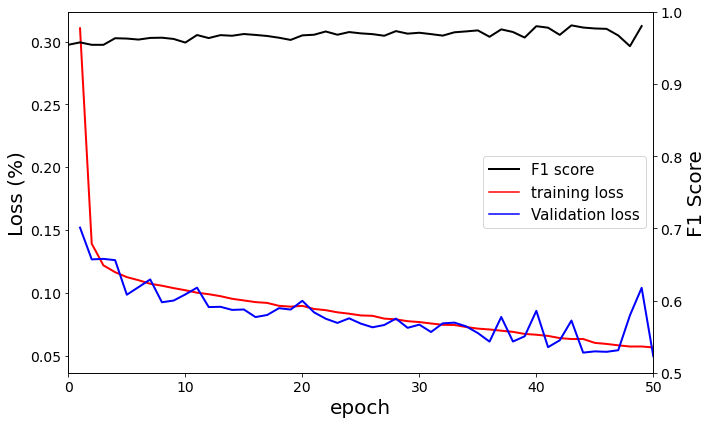

In [24]:
loss = np.asarray(history_dict[model_name][0].history['loss'])
val_loss = np.asarray(history_dict[model_name][0].history['val_loss'])
f1_scr = np.asarray(history_dict[model_name][0].history['f1 score'])

epoch = np.linspace(1,loss.size,loss.size)

#plot of training loss,  validation loss plots, and f1 score after each epoch.
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax2.plot(history_dict[model_name][0].history['f1 score'],'-',color='k',linewidth='2',label = 'F1 score')
ax2.plot(100,100,'-',label = 'training loss',c='r')
ax2.plot(100,100,'-',label = 'Validation loss',c='b')
ax.plot(epoch,loss,'-',color='r',linewidth='2',label = 'training loss')
ax.plot(epoch,val_loss,'-',color='b',linewidth='2',label = 'validation loss')
ax.set_xlim([0,len(history_dict[model_name][0].history['loss'])])

ax2.set_ylim([0.5,1])
ax.set_xlabel('epoch',fontsize=20)
ax.set_ylabel('Loss (%)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)
ax2.set_ylabel('F1 Score',fontsize=20)
plt.legend(loc='center right',fontsize=15)
plt.tight_layout()
#plt.savefig('valloss.png')

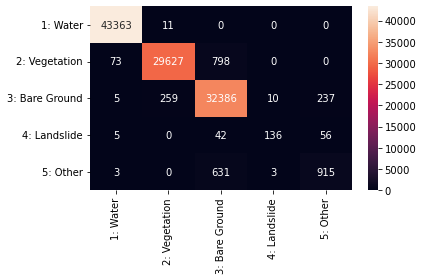

In [25]:
classes = ['1: Water',
           '2: Vegetation',
           '3: Bare Ground',
           '4: Landslide',
           '5: Other']
# Predict for test data 
Y_testPredicted = model.predict(X_test)

# Calculate and display the error metrics
y_pred=np.argmax(Y_testPredicted, axis=1)
y_test=np.argmax(Y_test, axis=1)

#Compute confusion matrix from ytest and ypredicted
mat = confusion_matrix(y_test, y_pred)

#Create dataframe to store label predictions
cm = pd.DataFrame(mat, index = classes, columns = classes)

#plot confusion matrix
sn.heatmap(cm, annot=True, fmt='d')
plt.tight_layout()
plt.savefig('cm.png')

In [26]:
#Use model to predict on all features
predicted = model.predict(features)
predicted = np.argmax(predicted,axis=1)

#Export raster generated by model
prediction = np.reshape(predicted, (features1.RasterYSize, features1.RasterXSize))
outFile = 'Mudcreek_LS_NN_predicted.tif'
raster.export(prediction, features1, filename=outFile, dtype='float')

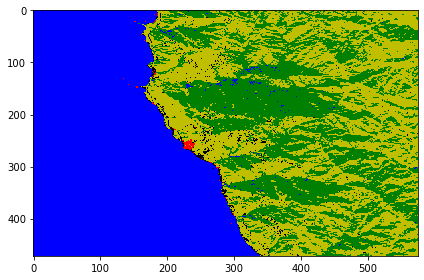

In [27]:
#Create map of model outputs
x = np.arange(0,prediction.shape[0],1)
y = np.arange(0,prediction.shape[1],1)
cMap = c.ListedColormap(['b','g','y','r','k'])
plt.pcolormesh(y,x, prediction,cmap=cMap)
plt.ylim(plt.ylim()[::-1]);
plt.tight_layout()
#plt.savefig('prediction.png')